# 1. Import

In [ ]:
!pip install gensim
!pip install sastrawi

In [ ]:
# General Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud

import csv
import requests
import string
import nltk
pd.options.mode.chained_assignment = None
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Preprocessing Import
import re
from io import StringIO
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import gensim
import tensorflow as tf
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Evaluation
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Data Preprocessing


## 2.1. Data Load

In [ ]:
url = 'https://drive.google.com/uc?id=1HOGlUBSFRtih0DQCzWpOdqLjdgvgPmgM'
df = pd.read_csv(url)
df.head()

,reviewId,userName,score,content,thumbsUpCount,at
0,03886b9c-6a14-4e77-84a3-103bb2c8f301,Pengguna Google,5,"sangat bagus,cepat,bisa di bacakan oleh cici a...",0,2025-09-14 08:14:05
1,297938a9-894e-4637-84b4-a6bcec2eb6fa,Pengguna Google,1,bagusan Chatgpt,0,2025-09-14 07:59:42
2,e65a8526-d821-4976-807e-c44d3f0c8a41,Pengguna Google,4,sangat baik,0,2025-09-14 07:33:58
3,749311a0-35bd-43a2-8381-b0b0162cb65a,Pengguna Google,1,jelek,0,2025-09-14 07:28:51
4,9ae46c67-e82d-4d5f-991e-b947f8cfad70,Pengguna Google,5,bagus aku suka buat cerita di ai anj seru soal...,0,2025-09-14 07:05:54


## 2.2. Data Cleaning

In [ ]:
df.isna().sum()

,0
reviewId,0
userName,0
score,0
content,0
thumbsUpCount,0
at,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df_clean = df.copy()

In [ ]:
def cleaning(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'RT\s+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def casefolding(text):
  text = text.lower()
  return text

def tokenization(text):
  text = word_tokenize(text)
  return text

stopwords_indo = set(stopwords.words('indonesian'))
stopwords_eng = set(stopwords.words('english'))
custom_stopwords = {"iya", "yaa", "gak", "nya", "na", "sih", "ku", "di", "ga", "ya", "gaa"}
all_stopwords = stopwords_indo.union(stopwords_eng).union(custom_stopwords)

def filtering(words):
    return [word for word in words if word not in all_stopwords]

def toSentence(list_words):
  sentence = ' '.join(list_words)
  return sentence

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(words):
    return [stemmer.stem(word) for word in words]


slangwords = {"gk": "tidak", "ga": "tidak", "gak": "tidak", "lg": "lagi", "yg": "yang",
              "dr": "dari", "km": "kamu", "klo" : "kalau", "udh" : "udah", "bngt" : "banget",
              "bgt":"banget"}

def fix_slang(text):
  words = text.split()
  fixed_words = []
  for word in words:
    if word.lower() in slangwords:
      fixed_words.append(slangwords[word.lower()])
    else:
      fixed_words.append(word)

  fixed_text = ' '.join(fixed_words)
  return fixed_text


clean_df = pd.DataFrame()
clean_df['text_clean'] = df['content'].apply(cleaning)
clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefolding)
clean_df['text_slangwords'] = clean_df['text_casefolding'].apply(fix_slang)
clean_df['text_tokenization'] = clean_df['text_slangwords'].apply(tokenization)
clean_df['text_filtering'] = clean_df['text_tokenization'].apply(filtering)
clean_df['text_stemming'] = clean_df['text_filtering'].apply(stemming)
clean_df['text_akhir'] = clean_df['text_stemming'].apply(toSentence)

In [ ]:
clean_df.head()

,text_clean,text_casefolding,text_slangwords,text_tokenization,text_filtering,text_stemming,text_akhir
0,sangat baguscepatbisa di bacakan oleh cici ai ...,sangat baguscepatbisa di bacakan oleh cici ai ...,sangat baguscepatbisa di bacakan oleh cici ai ...,"[sangat, baguscepatbisa, di, bacakan, oleh, ci...","[baguscepatbisa, bacakan, cici, ai, inijyga, f...","[baguscepatbisa, baca, cici, ai, inijyga, foto...",baguscepatbisa baca cici ai inijyga foto ai idola
1,bagusan Chatgpt,bagusan chatgpt,bagusan chatgpt,"[bagusan, chatgpt]","[bagusan, chatgpt]","[bagus, chatgpt]",bagus chatgpt
2,sangat baik,sangat baik,sangat baik,"[sangat, baik]",[],[],
3,jelek,jelek,jelek,[jelek],[jelek],[jelek],jelek
4,bagus aku suka buat cerita di ai anj seru soal...,bagus aku suka buat cerita di ai anj seru soal...,bagus aku suka buat cerita di ai anj seru soal...,"[bagus, aku, suka, buat, cerita, di, ai, anj, ...","[bagus, suka, cerita, ai, anj, seru, yap, prot...","[bagus, suka, cerita, ai, anj, seru, yap, prot...",bagus suka cerita ai anj seru yap protes ahli ...


## 2.3. Data Labeling

In [ ]:
def label_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

# tambahkan kolom label
clean_df["sentiment"] = df["score"].apply(label_sentiment)

print(clean_df['sentiment'].value_counts())

sentiment
positive    9501
negative    2020
neutral      479
Name: count, dtype: int64


In [ ]:
clean_df

,text_clean,text_casefolding,text_slangwords,text_tokenization,text_filtering,text_stemming,text_akhir,sentiment
0,sangat baguscepatbisa di bacakan oleh cici ai ...,sangat baguscepatbisa di bacakan oleh cici ai ...,sangat baguscepatbisa di bacakan oleh cici ai ...,"[sangat, baguscepatbisa, di, bacakan, oleh, ci...","[baguscepatbisa, bacakan, cici, ai, inijyga, f...","[baguscepatbisa, baca, cici, ai, inijyga, foto...",baguscepatbisa bacakan cici ai inijyga foto ai...,positive
1,bagusan Chatgpt,bagusan chatgpt,bagusan chatgpt,"[bagusan, chatgpt]","[bagusan, chatgpt]","[bagus, chatgpt]",bagusan chatgpt,negative
2,sangat baik,sangat baik,sangat baik,"[sangat, baik]",[],[],,positive
3,jelek,jelek,jelek,[jelek],[jelek],[jelek],jelek,negative
4,bagus aku suka buat cerita di ai anj seru soal...,bagus aku suka buat cerita di ai anj seru soal...,bagus aku suka buat cerita di ai anj seru soal...,"[bagus, aku, suka, buat, cerita, di, ai, anj, ...","[bagus, suka, cerita, ai, anj, seru, yap, prot...","[bagus, suka, cerita, ai, anj, seru, yap, prot...",bagus suka cerita ai anj seru yap protes ahli ...,positive
...,...,...,...,...,...,...,...,...
11995,kalau minta soal selalu tidak nyambung,kalau minta soal selalu tidak nyambung,kalau minta soal selalu tidak nyambung,"[kalau, minta, soal, selalu, tidak, nyambung]",[nyambung],[nyambung],nyambung,negative
11996,aku suka aplikasi ini karena bisa membuat kita...,aku suka aplikasi ini karena bisa membuat kita...,aku suka aplikasi ini karena bisa membuat kita...,"[aku, suka, aplikasi, ini, karena, bisa, membu...","[suka, aplikasi]","[suka, aplikasi]",suka aplikasi,neutral
11997,kita bisa berbicara dengean cici apa saja sema...,kita bisa berbicara dengean cici apa saja sema...,kita bisa berbicara dengean cici apa saja sema...,"[kita, bisa, berbicara, dengean, cici, apa, sa...","[berbicara, dengean, cici, semau]","[bicara, dengean, cici, mau]",berbicara dengean cici semau,positive
11998,bagusss banget kalo mau curhat gampang,bagusss banget kalo mau curhat gampang,bagusss banget kalo mau curhat gampang,"[bagusss, banget, kalo, mau, curhat, gampang]","[bagusss, banget, kalo, curhat, gampang]","[bagusss, banget, kalo, curhat, gampang]",bagusss banget kalo curhat gampang,positive


# 3. Data Understanding

# 3.1 Distribusi Label

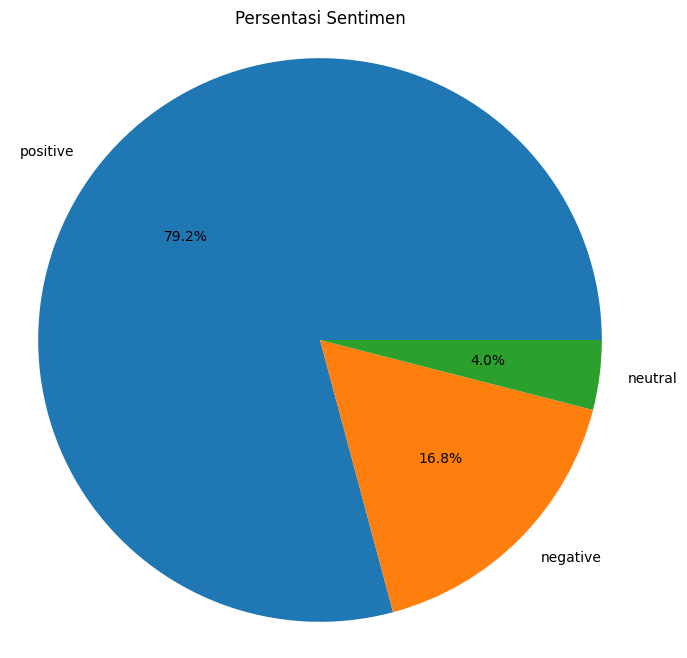

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(clean_df['sentiment'].value_counts(), labels=clean_df['sentiment'].value_counts().index, autopct='%1.1f%%')
plt.title('Persentasi Sentimen')
plt.axis('equal')
plt.show()

## 3.2 Frekuensi Kata

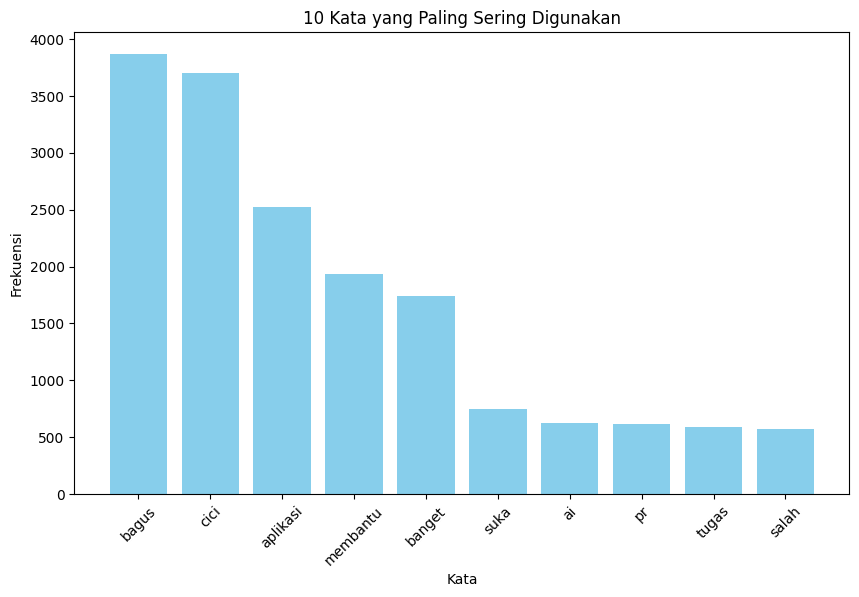

In [ ]:
all_text = ' '.join(clean_df['text_akhir'])
all_words = all_text.split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('10 Kata yang Paling Sering Digunakan')
plt.xticks(rotation=45)
plt.show()

### 3.2.1 Frekuensi Kata pada Label Positif

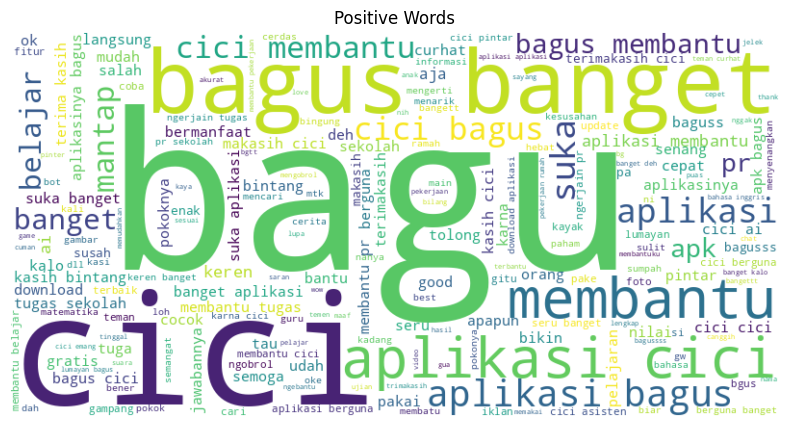

In [ ]:
positive_text = ' '.join(clean_df[clean_df['sentiment'] == 'positive']['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

### 3.2.2 Frekuensi Kata pada Label Negatif

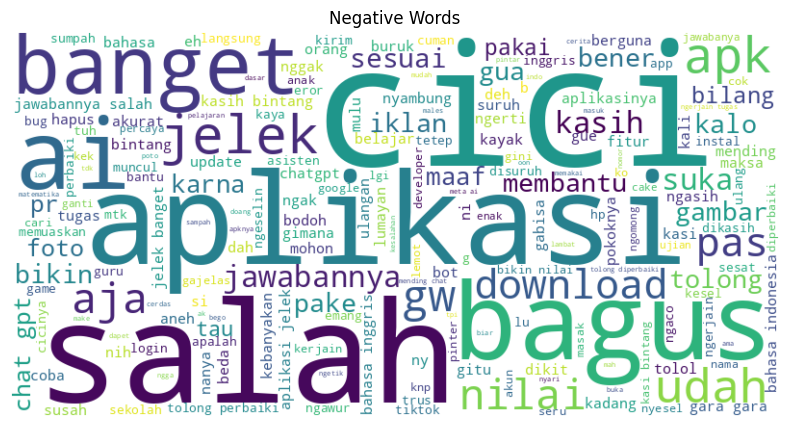

In [ ]:
negative_text = ' '.join(clean_df[clean_df['sentiment'] == 'negative']['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

### 3.2.3 Frekuensi Kata pada Label Netral

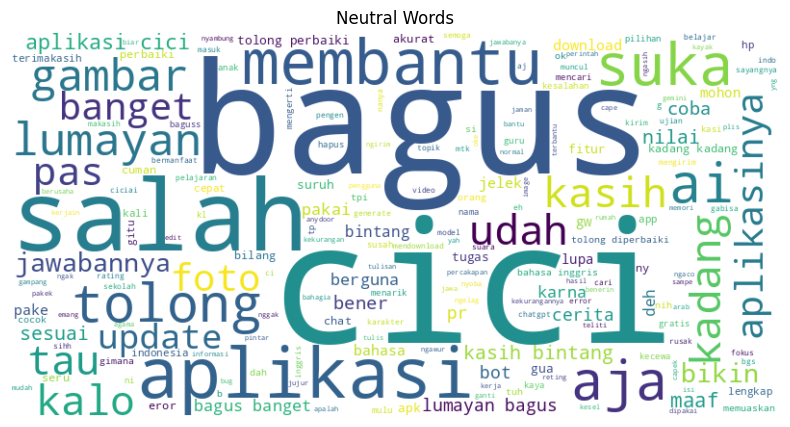

In [ ]:
neutral_text = ' '.join(clean_df[clean_df['sentiment'] == 'neutral']['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(neutral_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Words')
plt.show()

# 4. Modeling

Karena dataset imbalance jadi harus dibuat balance dengan oversampling pada label minoritas. Akan tetapi dpaat menyebabkan bias pada beberapa label.

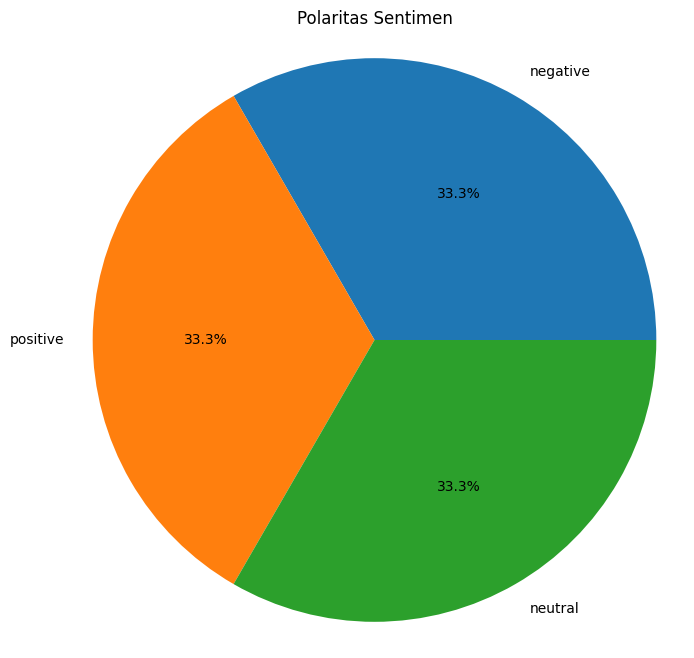

In [ ]:
counts = clean_df['sentiment'].value_counts()
target_count = counts['positive']

df_pos = clean_df[clean_df['sentiment'] == 'positive']
df_neu = clean_df[clean_df['sentiment'] == 'neutral']
df_neg = clean_df[clean_df['sentiment'] == 'negative']

df_neu_oversampled = df_neu.sample(target_count, replace=True, random_state=42)
df_neg_oversampled = df_neg.sample(target_count, replace=True, random_state=42)

df_balanced = pd.concat([df_pos, df_neu_oversampled, df_neg_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(8, 8))
plt.pie(df_balanced['sentiment'].value_counts(), labels=df_balanced ['sentiment'].value_counts().index, autopct='%1.1f%%')
plt.title('Polaritas Sentimen')
plt.axis('equal')
plt.show()

## 4.1. Experiment Model 1

In [ ]:
X = df_balanced['text_akhir']
y = df_balanced['sentiment']

tfidf = TfidfVectorizer(max_features=2000, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42),
                           param_grid = Param,
                           scoring = "accuracy",
                           cv = 10,
                           verbose = 0,
                           n_jobs = -1)

grid_search.fit(X_train_scaled, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 78.20 %
Best Parameters: {'C': 16.768329368110066, 'penalty': 'l2'}


## 4.2 Experiment Model 2

In [ ]:
w2v_model = Word2Vec(sentences=df_balanced['text_stemming'], vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
vocab = w2v_model.wv.key_to_index
word_index = {word: idx+1 for idx, word in enumerate(vocab)}

def tokens_to_seq(tokens):
    return [word_index[word] for word in tokens if word in word_index]

df_eperiment2 = df_balanced.copy()
df_eperiment2['seq'] = df_eperiment2['text_stemming'].apply(tokens_to_seq)
df_eperiment2[['text_stemming', 'seq']].head()

,text_stemming,seq
0,"[apa, gw, ngerjain, mtk, nguaworjawabannya, sa...","[83, 34, 74, 122, 3069, 4]"
1,"[aplikasi, bagus, kaya, iklan, suka, ngebug, g...","[3, 2, 100, 55, 9, 680, 1244, 179, 1080, 261, ..."
2,"[diandelin, banget, capek, nulis, paham]","[1288, 6, 250, 454, 90]"
3,"[bagus, banget]","[2, 6]"
4,"[lumayan, bagus, karna, bagus, aja, deh]","[22, 2, 38, 2, 11, 44]"


In [ ]:
max_len = max(df_eperiment2['seq'].apply(len))
label_sentiment = {'negative': 0, 'neutral': 1, 'positive': 2}
df_eperiment2['sentiment'] = df_eperiment2['sentiment'].map(label_sentiment)

X = pad_sequences(df_eperiment2['seq'], maxlen=max_len, padding='post')
y = np.array(df_eperiment2['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, idx in word_index.items():
    embedding_vector = w2v_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

print("Shape embedding matrix:", embedding_matrix.shape)

Shape embedding matrix: (6775, 200)


In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,355,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,355,000 (5.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,355,000 (5.17 MB)

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nLatihannya Sudah Cukup ya!")
            self.model.stop_training = True

custom_callback = CustomCallback()

In [ ]:
history_lstm = model_lstm.fit(X_train,
                         y_train,
                         epochs=30,
                         batch_size=32,
                         validation_data=(X_test, y_test),
                         callbacks=[custom_callback])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.5281 - loss: 0.9663 - val_accuracy: 0.6264 - val_loss: 0.8372
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.6377 - loss: 0.8231 - val_accuracy: 0.6753 - val_loss: 0.7268
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.6872 - loss: 0.7150 - val_accuracy: 0.7136 - val_loss: 0.6288
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7201 - loss: 0.6399 - val_accuracy: 0.7506 - val_loss: 0.5549
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.7576 - loss: 0.5590 - val_accuracy: 0.7681 - val_loss: 0.5445
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7864 - loss: 0.5047 - val_accuracy: 0.8069 - val_loss: 0.4577
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8132 - loss: 0.4452 - val_accuracy: 0.8186 - val_loss: 0.4341
Epoch 8/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8290 - loss: 0.4090 - 

## 4.3. Experiment Model 3

In [ ]:
df_eperiment3 = df_balanced.copy()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_eperiment3['text_stemming'])
sequences = tokenizer.texts_to_sequences(df_eperiment3['text_stemming'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

label_sentiment = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = df_eperiment3['sentiment'].map(label_sentiment)
y = to_categorical(labels, num_classes=3)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [ ]:
model_gru = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=vocab_size, output_dim=16, input_length=max_len),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(128)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax'),
])

model_gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_gru.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 55, 16)         │       108,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 55, 128)        │        31,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 256)            │       198,144 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,379 (1.45 MB)

 Trainable params: 379,379 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_gru = model_gru.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[custom_callback]
  )

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5425 - loss: 0.9030 - val_accuracy: 0.8067 - val_loss: 0.5040
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8345 - loss: 0.4428 - val_accuracy: 0.8435 - val_loss: 0.4032
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8640 - loss: 0.3494 - val_accuracy: 0.8472 - val_loss: 0.4100
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8759 - loss: 0.3196 - val_accuracy: 0.8484 - val_loss: 0.3788
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.8856 - loss: 0.2863 - val_accuracy: 0.8634 - val_loss: 0.3456
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8879 - loss: 0.2764 - val_accuracy: 0.8691 - val_loss: 0.3534
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8882 - loss: 0.2684 - val_accuracy: 0.8606 - val_loss: 0.3630
Epoch 8/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8958 - loss: 0.2491 - 

# 5. Evaluation

## 5.1. Evaluation 1

In [ ]:
model_lr = LogisticRegression(C=16.768329368110066, penalty='l2', random_state=42)
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=['Negatif', 'Netral', 'Positif']))

              precision    recall  f1-score   support

     Negatif       0.77      0.81      0.79      1880
      Netral       0.83      0.79      0.81      1915
     Positif       0.75      0.75      0.75      1906

    accuracy                           0.78      5701
   macro avg       0.78      0.78      0.78      5701
weighted avg       0.78      0.78      0.78      5701



## 5.2 Evaluation 2

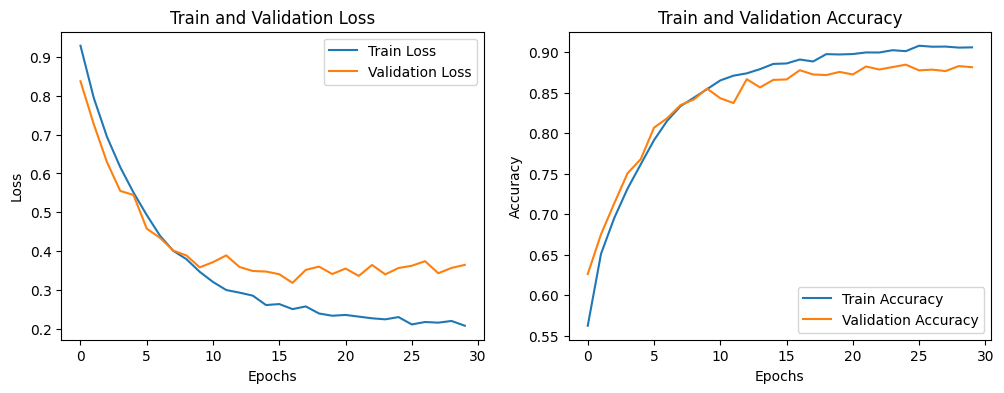

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
predictions = model_lstm.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

report = classification_report(true_labels, predicted_labels, target_names=['Negatif', 'Netral', 'Positif'])
print(report)

179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
              precision    recall  f1-score   support

     Negatif       0.69      0.78      0.73      1880
      Netral       0.87      0.53      0.66      1915
     Positif       0.66      0.84      0.74      1906

    accuracy                           0.72      5701
   macro avg       0.74      0.72      0.71      5701
weighted avg       0.74      0.72      0.71      5701



## 5.3 Evaluation 3

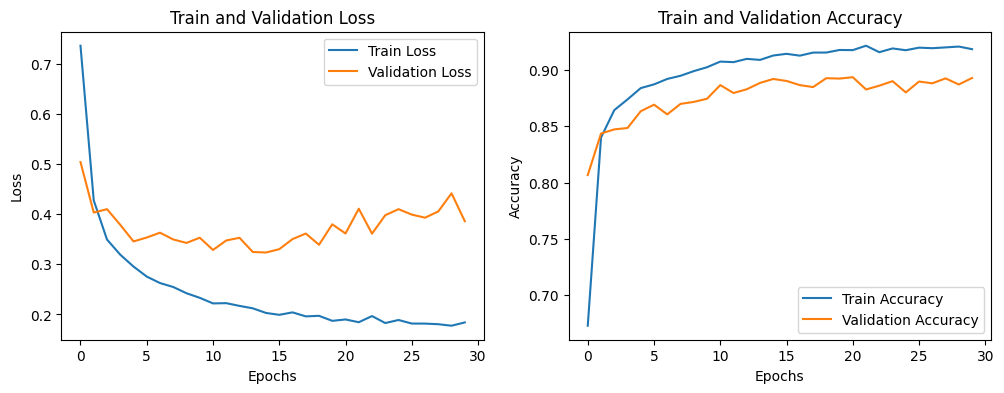

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
predictions = model_gru.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

report = classification_report(true_labels, predicted_labels, target_names=['Negatif', 'Netral', 'Positif'])
print(report)

179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
              precision    recall  f1-score   support

     Negatif       0.90      0.92      0.91      1880
      Netral       0.93      0.89      0.91      1915
     Positif       0.85      0.87      0.86      1906

    accuracy                           0.89      5701
   macro avg       0.89      0.89      0.89      5701
weighted avg       0.89      0.89      0.89      5701



# 6. Inference

In [ ]:
new_texts = [
    "cici tidak sesuai apa yang di minta jawabannya malah salah semua sangat tidak masuk akal jawabannya",
    "Saya jadi mudah mengerjakan tugas di sekolah"
]

sequences = tokenizer.texts_to_sequences(new_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

predictions = model_gru.predict(padded_sequences)
predicted_classes = np.argmax(predictions, axis=1)

label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}

for text, pred in zip(new_texts, predicted_classes):
    print(f"Teks: {text} \nPrediksi Sentimen: {label_map[pred]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Teks: cici tidak sesuai apa yang di minta jawabannya malah salah semua sangat tidak masuk akal jawabannya 
Prediksi Sentimen: Negatif

Teks: Saya jadi mudah mengerjakan tugas di sekolah 
Prediksi Sentimen: Positif



In [ ]:
!pip freeze > requirements.txt

End Code.